# Composite priors

A common usecase is to have a multidimensional prior with different distributions in each dimension. There are a couple different ways to achieve this...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import scipy.stats
import numpy as np

import pylab as plt

from toolz import compose
from swyft.prior import Prior, PriorTruncator
from swyft.utils import tensor_to_array, array_to_tensor

In [3]:
loc = torch.tensor([1.0, -3.2])
scale = torch.tensor([0.1, 2.1])

upper = torch.tensor([2.5, 3.1])
lower = torch.tensor([0.1, -2.0])

n_parameters = len(loc) + len(upper)

## Torch Distributions

In [4]:
normal = torch.distributions.Normal(loc, scale)
uniform = torch.distributions.Uniform(lower, upper)

composite_prior_torch = Prior(
    cdf=compose(tensor_to_array, lambda x: torch.cat([normal.cdf(x[:, :2]), uniform.cdf(x[:, 2:4])], dim=1), array_to_tensor),
    icdf=compose(tensor_to_array, lambda x: torch.cat([normal.icdf(x[:, :2]), uniform.icdf(x[:, 2:4])], dim=1), array_to_tensor),
    log_prob=compose(tensor_to_array, lambda x: torch.cat([normal.log_prob(x[:, :2]), uniform.log_prob(x[:, 2:4])], dim=1), array_to_tensor),
    n_parameters=n_parameters,
)

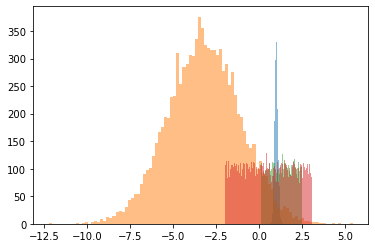

In [5]:
samples = PriorTruncator(composite_prior_torch, bound=None).sample(10_000)
for i in range(n_parameters):
    _ = plt.hist(samples[:, i], bins=100, alpha=0.5)

## SciPy Distributions

In [6]:
normal_scipy = scipy.stats.norm(loc, scale)
uniform_scipy = scipy.stats.uniform(lower, upper)

composite_prior_scipy = Prior(
    cdf=lambda x: np.concatenate([normal.cdf(x[:2]), uniform.cdf(x[2:4])]),
    icdf=lambda x: np.concatenate([normal.ppf(x[:2]), uniform.ppf(x[2:4])]),
    log_prob=lambda x: np.concatenate([normal.logpdf(x[:2]), uniform.logpdf(x[2:4])]),
    n_parameters=n_parameters,
)

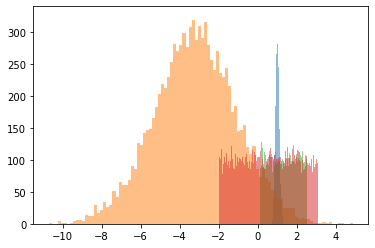

In [7]:
samples_scipy = PriorTruncator(composite_prior_torch, bound=None).sample(10_000)
for i in range(n_parameters):
    _ = plt.hist(samples_scipy[:, i], bins=100, alpha=0.5)